<a href="https://colab.research.google.com/github/aderylo/movie-genres-prediction/blob/master/movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install contractions
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np 
import re
import pandas as pd 
import nltk 
import contractions
from bs4 import BeautifulSoup
from autocorrect import Speller

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
ss = nltk.SnowballStemmer(language = 'english')
w = [ss.stem(word) for word in ["exciting"]]
print(w)

['excit']


## Geting dataset 
Unfortuently, reading directly a file from a git url wasn't working properly, so the esiest solution was to clone whole repo. 

In [5]:
!git clone https://github.com/aderylo/movie-genres-prediction.git

Cloning into 'movie-genres-prediction'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [6]:
df = pd.read_csv('movie-genres-prediction/mpst_full_data.csv', delimiter=',')
nRow, nCol = df.shape
df.head(5)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


## Cleaning data

In [7]:
def strip_html_tags(text):
    """ 
    This function will remove all the occurrences of html tags from the text.
    
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" after removal of html tags.
        
    Example:
    Input : This is a nice place to live. <IMG>
    Output : This is a nice place to live.  
    """
    # Initiating BeautifulSoup object soup.
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [8]:
def remove_links(text):
    """
    This function will remove all the occurrences of links.
    
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" after removal of all types of links.
        
    Example:
    Input : To know more about cats and food & website: catster.com  visit: https://catster.com//how-to-feed-cats
    Output : To know more about cats and food & website: visit:     
    
    """
    
    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

In [9]:
def spelling_correction(text):
    ''' 
    This function will correct spellings.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Text after corrected spellings.
        
    Example: 
    Input : This is Oberois from Dlhi who came heree to studdy.
    Output : This is Oberoi from Delhi who came here to study.
    '''
    # Check for spellings in English language
    spell = Speller(lang='en')
    Corrected_text = spell(text)
    return Corrected_text

In [10]:
stoplist = nltk.corpus.stopwords.words('english') 
stoplist = set(stoplist)
def removing_stopwords(text):
    """This function will remove stopwords which doesn't add much meaning to a sentence 
       & they can be remove safely without comprimising meaning of the sentence.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Text after omitted all stopwords.
        
    Example: 
    Input : This is Kajal from delhi who came here to study.
    Output : ["'This", 'Kajal', 'delhi', 'came', 'study', '.', "'"] 
    
   """
    # repr() function actually gives the precise information about the string
    text = repr(text)
    # Text without stopwords
    No_StopWords = [word for word in nltk.tokenize.word_tokenize(text) if word.lower() not in stoplist ]
    # Convert list of tokens_without_stopwords to String type.
    words_string = ' '.join(No_StopWords)    
    return words_string

In [11]:
def tokenizing(text): 
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  return ' '.join(tokenizer.tokenize(text.lower()))

In [12]:
def clean_text(text): 
  text = strip_html_tags(text)
  text = remove_links(text)
  # text = spelling_correction(text) # for faster execution remove this one
  text = contractions.fix(text)
  text = tokenizing(text)
  text = removing_stopwords(text)
  text = re.sub("\S*\d\S*", "", text).strip()
  return text

#Takes around a minute or so
df['preprocessed_plots'] = df['plot_synopsis'].apply(clean_text)

In [34]:
df['preprocessed_plots']

"'note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known three faces fear telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset series strange phone calls caller soon identified frank ex pimp recently escaped prison rosy terrified testimony landed man jail looking solace rosy phones lesbian lover mary lynda alfonsi two women estranged time rosy certain one help mary agrees come night seconds later frank calls promising matter calls protection revenge unknown rosy mary caller impersonating frank marry arrives rosy apartment soon best calm rosy nerves gives panic struck woman tranquillizer puts bed later night rosy sleeps mary gets bed pens note confession one making strange phone calls learned franks escape prison knowing rosy would call help explains felt way coming back life breakup busy writing fails notice intruder apartmen

In [14]:
def remove_sapces(text): 
  return text.replace(" ","")

df['tags']=df['tags'].apply(remove_sapces)
df['tags']

0                    cult,horror,gothic,murder,atmospheric
1                                                 violence
2                                                 romantic
3                      inspiring,romantic,stupid,feel-good
4        cruelty,murder,dramatic,cult,violence,atmosphe...
                               ...                        
14823                                        comedy,murder
14824                              goodversusevil,violence
14825                                              antiwar
14826                                               murder
14827                                        christianfilm
Name: tags, Length: 14828, dtype: object

### How well did we clean the data? 

In [15]:
def max_len(x):
    a=x.split()
    return len(a)

v=Tokenizer()
v.fit_on_texts(df['preprocessed_plots'])
vocab_size = len(v.word_index) + 1


print(max(df['preprocessed_plots'].apply(max_len)))
print(vocab_size)

5833
125854


## Encoding before training

In [16]:
train=df.loc[df.split=='train']
test=df.loc[df.split=='test']
cv=df.loc[df.split=="val"]

train=train.reset_index()
test=test.reset_index()
cv=cv.reset_index()


In [17]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train = vectorizer.fit_transform(train['tags']).toarray()
y_test = vectorizer.transform(test['tags']).toarray()

print(y_train)
print(vectorizer.inverse_transform(y_train)[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
['atmospheric' 'cult' 'gothic' 'horror' 'murder']


In [18]:
vect=Tokenizer()
vect.fit_on_texts(train['plot_synopsis'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)

122195


In [19]:
encoded_docs_train = vect.texts_to_sequences(train['preprocessed_plots'])
max_length = vocab_size
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=1200, padding='post')
print(padded_docs_train)

[[ 4660 62208  2514 ...     0     0     0]
 [ 4481   143   875 ...     0     0     0]
 [ 4094  2892 28344 ...   140  6946  2001]
 ...
 [62209  2717   539 ...     0     0     0]
 [25350  5118  2731 ...     0     0     0]
 [ 1269  2392  2530 ...     0     0     0]]


In [20]:
encoded_docs_test =  vect.texts_to_sequences(test['preprocessed_plots'])
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=1200, padding='post')
encoded_docs_cv = vect.texts_to_sequences(cv['preprocessed_plots'])
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=1200, padding='post')

## Model 

In [21]:
model = keras.Sequential()
# Configuring the parameters
model.add(layers.Embedding(vocab_size, output_dim=50, input_length=1200))
model.add(layers.LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(layers.Dense(71, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 50)          6109750   
                                                                 
 lstm (LSTM)                 (None, 1200, 128)         91648     
                                                                 
 dropout (Dropout)           (None, 1200, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 71)                4615      
                                                                 
Total params: 6,255,421
Trainable params: 6,255,421
Non-

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

In [23]:
history = model.fit(padded_docs_train,y_train,
                        epochs = 10,
                        verbose = 1,
                        validation_data=(padded_docs_test, y_test),
                        batch_size=16,
                        callbacks=callbacks)

Epoch 1/10
594/594 [==============================] - 75s 109ms/step - loss: 0.1742 - tp: 1485.0000 - fp: 9199.0000 - tn: 636498.0000 - fn: 26537.0000 - accuracy: 0.9470 - precision: 0.1390 - recall: 0.0530 - auc: 0.7507 - val_loss: 0.1501 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 201564.0000 - val_fn: 9022.0000 - val_accuracy: 0.9572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8110
Epoch 2/10
594/594 [==============================] - 61s 103ms/step - loss: 0.1446 - tp: 263.0000 - fp: 496.0000 - tn: 645201.0000 - fn: 27759.0000 - accuracy: 0.9581 - precision: 0.3465 - recall: 0.0094 - auc: 0.8041 - val_loss: 0.1407 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 201564.0000 - val_fn: 9022.0000 - val_accuracy: 0.9572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8325
Epoch 3/10
594/594 [==============================] - 59s 99ms/step - loss: 0.1425 - tp: 53.0000 - fp: 145.0000 - tn: 645552.0000 - fn: 27969.0000 - accuracy: 0.9583 

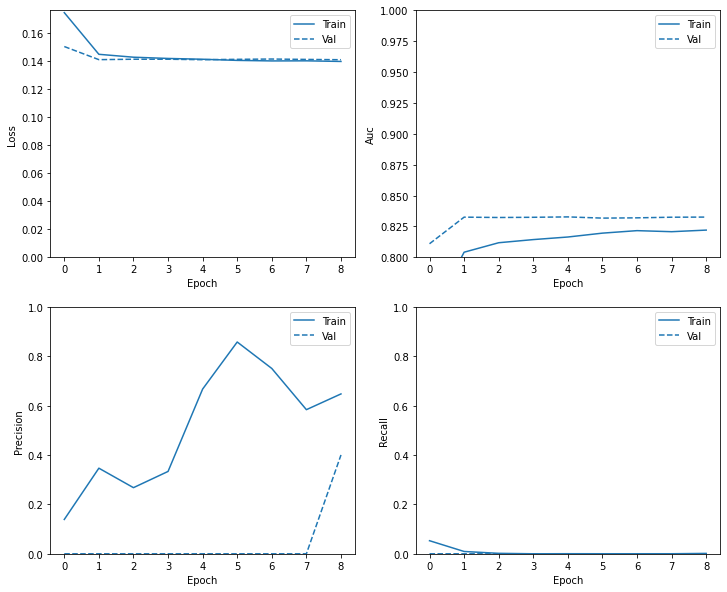

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [26]:
predictions=model.predict([padded_docs_test])
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

For threshold:  0.1
Micro-average quality numbers
Precision: 0.2109, Recall: 0.5695, F1-measure: 0.3078
For threshold:  0.2
Micro-average quality numbers
Precision: 0.2731, Recall: 0.3664, F1-measure: 0.3129
For threshold:  0.3
Micro-average quality numbers
Precision: 0.3464, Recall: 0.2315, F1-measure: 0.2776
For threshold:  0.4
Micro-average quality numbers
Precision: 0.4599, Recall: 0.0095, F1-measure: 0.0187
For threshold:  0.5
Micro-average quality numbers
Precision: 0.4000, Recall: 0.0002, F1-measure: 0.0004
For threshold:  0.6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.7
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.8
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.9
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
def predict_sample():
    t = train.sample(1)
    encoded_docs = vect.texts_to_sequences(t['preprocessed_plots'])
    padded_docs = pad_sequences(encoded_docs, maxlen=1200, padding='post')
    pred = model.predict(padded_docs).tolist()
    for i in range(len(pred[0])):
        if(pred[0][i] < 0.1):
            pred[0][i] = 0
        else:
            pred[0][i] = 1
    
    print("Original tags -->", t['tags'].values)
    print("Predicted tags -->", vectorizer.inverse_transform(pred))

predict_sample()

[[2001 2186 5876 ...    0    0    0]]
Original tags --> ['romantic,flashback']
Predicted tags --> [array(['comedy', 'cult', 'flashback', 'murder', 'psychedelic', 'revenge',
       'romantic', 'violence'], dtype='<U17')]


In [84]:
def predict_user_input(input : str):
  clean_input = clean_text(input)
  encoded_docs = vect.texts_to_sequences(clean_input)
  padded_docs = pad_sequences(encoded_docs, maxlen=1200, padding='post')
  pred = model.predict(padded_docs).tolist()
  for i in range(len(pred[0])):
      if(pred[0][i] < 0.1):
          pred[0][i] = 0
      else:
          pred[0][i] = 1
    
  print("Predicted tags -->", vectorizer.inverse_transform(pred)[0])

In [85]:
x = predict_user_input("""A meek Hobbit from the Shire and eight companions set out on
 a journey to destroy the powerful One Ring and save Middle-earth from the Dark Lord Sauron.""")

Predicted tags --> ['comedy' 'cult' 'flashback' 'murder' 'psychedelic' 'revenge' 'romantic'
 'violence']
